# Compare Ifremer and Cefficient of determination with each other to see how well the model fit the data (type of validation where the model fit the data better or worse geographically)

In [1]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [3]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files
import datetime
#plotting libraries
import cmocean.cm as cmo
from matplotlib import cm 
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker
import matplotlib
from numpy import pi


#my functions
from unweighted_least_square_fit import least_square_fit 
from char_LSF_curve import character_LSF
from monthly_mean import monthly_average
import cartopy_fig_module as cart

Import data for Ifremer SWH and CCMP2 WSP Characteristics from .npz files 

In [4]:
ifremer_swh = np.load('/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/char_lsf_5par_npz/ifremer_swhcor.npz')
ccmp2_wsp = np.load('/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/month_averaged_ccmp_v2_data/char_lsf_5par_npz/ccmp2_wsp_month_data_std_hfit.npz')


Redefine variables 

In [5]:
#For ifremer swh
swh_mean_m = ifremer_swh['swh_monthly_mean']
swh_std_m = ifremer_swh['swh_monthly_std']
swh_hfit_m = ifremer_swh['swh_hfit']

#For CCMP2 wsp 
wsp_mean_m = ccmp2_wsp['wsp_monthly_mean']
wsp_std_m = ccmp2_wsp['wsp_monthly_mean']
wsp_hfit_m = ccmp2_wsp['wsp_monthly_mean']

Set spatial variables 

In [6]:
lon = np.arange(0,360,1)
lat = np.arange(-66,67,1)
nlon = len(lon)
nlat = len(lat)

Compute the residual and residual normalized by the STD for each data point 

In [7]:
#For SWH:
residual_swh = swh_mean_m - swh_hfit_m
rchi_swh = (swh_mean_m - swh_hfit_m)/swh_std_m

#For WSP: 
residual_wsp = wsp_mean_m - wsp_hfit_m
rchi_wsp = (wsp_mean_m - wsp_hfit_m)/wsp_std_m

/home/lcolosi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lcolosi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Create a datetime time series for monthly data from 1993 to 2015

In [8]:
months = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]*23)
nt = len(months)

Compute the root mean square, chi-square statistic , reduced chi square statistics, and COD for each season 

In [9]:
#initialize variables
seasons = [[12,1,2], [3,4,5], [6,7,8], [9,10,11]]
nparameters = 5
dof = nt - nparameters

#initialize the dictionary that will hold all the resulting monthly mean, std, median, and nobs data
season_swh = {}
season_swh = {'rms': [],'chi': [],'rchi': [],'cod': []}
season_wsp = {}
season_wsp = {'rms': [],'chi': [],'rchi': [],'cod': []}
    

#initialize a seasonal loop that will go through each month 1 to 12 
for s in range(0,4):

    #call season:
    season = seasons[s]

    #initialize the indices where the months vector elements are equal to the month value of the loop. Therefore, we obtain all the 2D arrays of swh wave height data that has been collected during the month of January, February, etc. in our given time series. 
    bool_1 = months==season[0]
    bool_2 = months==season[1]
    bool_3 = months==season[2]
    ind_1 = bool_1 | bool_2
    ind = ind_1 |bool_3
    
    #apply the indice to the mean, residual, rchi for SWH and wsp to extect data collected just during the designated season
    swh_mean_s = np.ma.array(swh_mean_m[ind,:,:])
    swh_res_s = np.ma.array(residual_swh[ind,:,:])
    swh_rchi_s = np.ma.array(rchi_swh[ind,:,:])
    wsp_mean_s = np.ma.array(wsp_mean_m[ind,:,:])
    wsp_res_s = np.ma.array(residual_wsp[ind,:,:])
    wsp_rchi_s = np.ma.array(rchi_wsp[ind,:,:])
    
    #compute rms residual, chi_square statistic, and COD for each season:
    #For SWH: 
    rms_swh = np.sqrt(np.mean((swh_res_s)**2, axis = 0))
    chi_square_stat_swh = np.sum(swh_rchi_s, axis=0)
    rchi_square_stat_swh = np.sum(swh_rchi_s, axis=0)/dof
    cod_swh = 1 - (np.sum((swh_res_s)**2)/np.sum((swh_mean_s - np.mean(swh_mean_s))**2, axis=0))
    #For WSP: 
    rms_wsp = np.sqrt(np.mean((wsp_res_s)**2, axis=0))
    chi_square_stat_wsp = np.sum(wsp_rchi_s, axis=0)
    rchi_square_stat_wsp = np.sum(wsp_rchi_s, axis=0)/dof
    cod_wsp = 1 - (np.sum((wsp_res_s)**2, axis=0)/np.sum((wsp_mean_s - np.mean(wsp_mean_s))**2, axis=0))
    
    #save data in dictionaries 
    #For SWH:
    season_swh['rms'].append(rms_swh)
    season_swh['chi'].append(chi_square_stat_swh)
    season_swh['rchi'].append(rchi_square_stat_swh)
    season_swh['cod'].append(cod_swh)
    
    #For WSP: 
    season_wsp['rms'].append(rms_wsp)
    season_wsp['chi'].append(chi_square_stat_wsp)
    season_wsp['rchi'].append(rchi_square_stat_wsp)
    season_wsp['cod'].append(cod_wsp)

/home/lcolosi/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Compute the residual, chi square statistic, reduced chi square statistic, and COD for the entire time series

In [17]:
#For SWH:
swh_rms_total = np.sqrt(np.mean((residual_swh)**2, axis=0))
swh_chi_total = np.sum(rchi_swh, axis=0)
swh_rchi_total = np.sum(rchi_swh, axis=0)/dof
swh_cod_total = 1 - (np.sum((residual_swh)**2, axis=0)/np.sum((swh_mean_m - np.mean(swh_mean_m))**2, axis=0))

#For WSP:
wsp_rms_total = np.sqrt(np.mean((residual_wsp)**2, axis=0))
wsp_chi_total = np.sum(rchi_wsp, axis=0)
wsp_rchi_total = np.sum(rchi_wsp, axis=0)/dof
wsp_cod_total = 1 - (np.sum((residual_wsp)**2, axis=0)/np.sum((wsp_mean_m - np.mean(wsp_mean_m))**2, axis=0))

/home/lcolosi/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Assign key variables from dictionary as variables and convert variables to numpy arrays

In [11]:
#For SWH:
swh_rms_sea = np.ma.array(season_swh['rms'])
swh_chi_sea = np.ma.array(season_swh['chi'])
swh_rchi_sea = np.ma.array(season_swh['rchi'])
swh_cod_sea = np.ma.array(season_swh['cod'])

#For WSP:
wsp_rms_sea = np.ma.array(season_wsp['rms'])
wsp_chi_sea = np.ma.array(season_wsp['chi'])
wsp_rchi_sea = np.ma.array(season_wsp['rchi'])
wsp_cod_sea = np.ma.array(season_wsp['cod'])

### Plot the goodness of fit metrics for the least square fit for Ifremer swh and CCMP2 wsp 

#### Seasonal progressions

###### Residual 

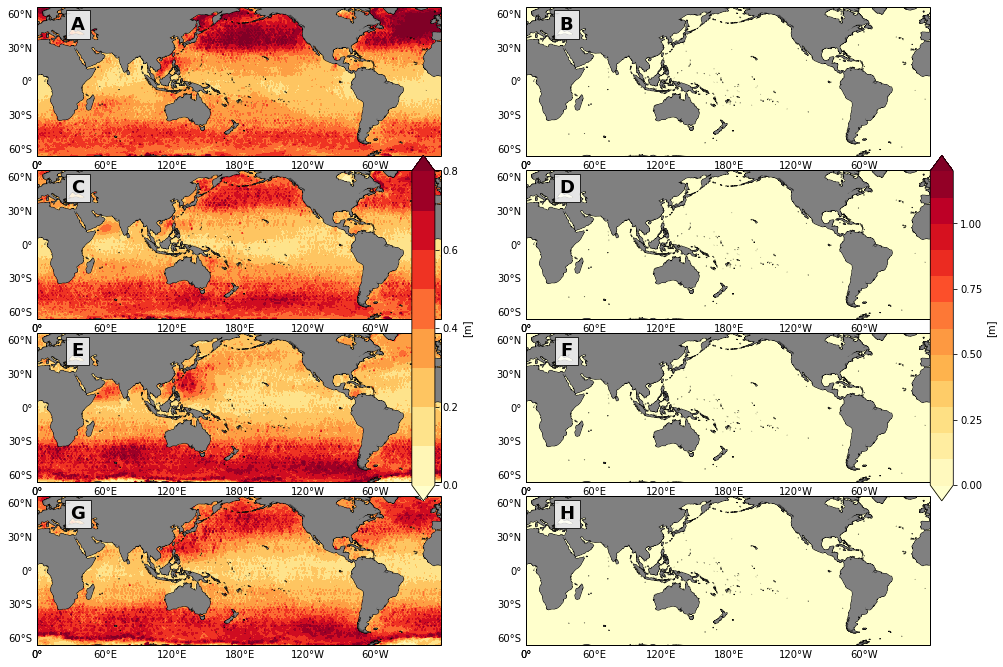

In [12]:
import cartopy.feature as cfeature

projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 0.9, 0.1)
cs1 = ax1.contourf(lon, lat, swh_rms_sea[0,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.45, .3, 0.02, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.3, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_rms_sea[0,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
cax2 = plt.axes([.90, .3, 0.02, 0.4])
cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 6, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 0.9, 0.1)
cs3 = ax3.contourf(lon, lat, swh_rms_sea[1,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.3, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_rms_sea[1,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
cart.set_subplots(ax5, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 0.9, 0.1)
cs5 = ax5.contourf(lon, lat, swh_rms_sea[2,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax5 = plt.axes([.47, .17, 0.01, 0.16])
#cart.set_cbar(cs5, cax5, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
cart.set_subplots(ax6, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.3, 0.1)
cs6 = ax6.contourf(lon, lat, wsp_rms_sea[2,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax6 = plt.axes([.92, .33, 0.01, 0.16])
#cart.set_cbar(cs6, cax6, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

############## Subplot 7  #################
cart.set_subplots(ax7, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 0.9, 0.1)
cs7 = ax7.contourf(lon, lat, swh_rms_sea[3,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax7, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax7 = plt.axes([.47, .06, 0.01, 0.16])
#cart.set_cbar(cs7, cax7, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax7, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax7, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'G', fs_shade = 28, fs_main = 18)

############## Subplot 8  #################
cart.set_subplots(ax8, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.3, 0.1)
cs8 = ax8.contourf(lon, lat, wsp_rms_sea[3,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax8, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax8 = plt.axes([.92, .14, 0.01, 0.16])
#cart.set_cbar(cs8, cax8, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax8, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
#ax8.text(0.5, -0.21, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax8.transAxes, fontsize=15)
cart.subplot_label(ax8, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'H', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/ccmp2_ifremer_gof_res', bbox_inches = 'tight', dpi=300)




###### Chi Square Statistic

ValueError: arange: cannot compute length

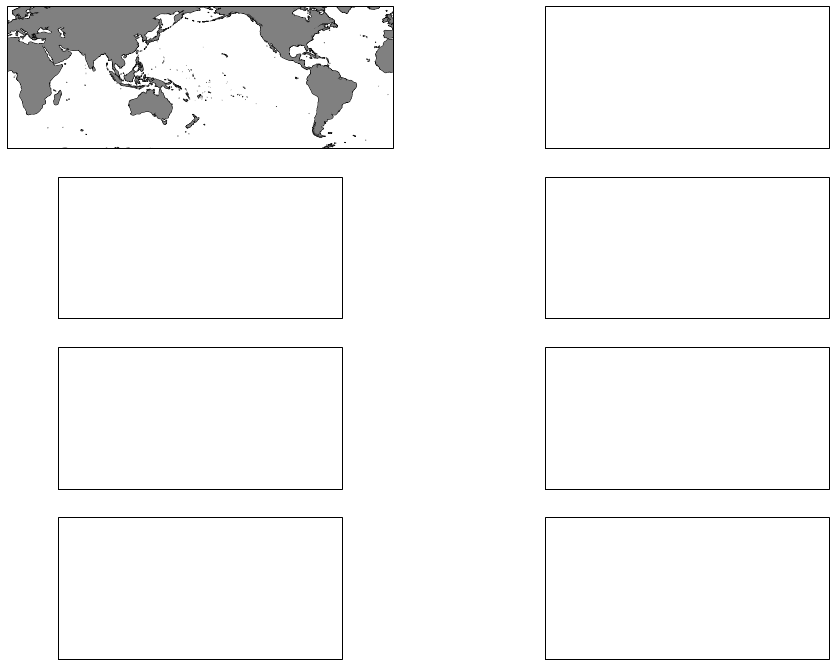

In [13]:
import cartopy.feature as cfeature

projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(np.min(swh_chi_sea), np.max(swh_chi_sea), 0.1)
cs1 = ax1.contourf(lon, lat, swh_chi_sea[0,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.45, .3, 0.02, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(np.min(wsp_chi_sea), np.max(wsp_chi_sea), 0.1)
cs2 = ax2.contourf(lon, lat, wsp_chi_sea[0,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
cax2 = plt.axes([.90, .3, 0.02, 0.4])
cart.set_cbar(cs2, cax2, fig, cbar_label ='', nbins = 6, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(np.min(swh_chi_sea), np.max(swh_chi_sea), 0.1)
cs3 = ax3.contourf(lon, lat, swh_chi_sea[1,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(np.min(wsp_chi_sea), np.max(wsp_chi_sea), 0.1)
cs4 = ax4.contourf(lon, lat, wsp_chi_sea[1,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
cart.set_subplots(ax5, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(np.min(swh_chi_sea), np.max(swh_chi_sea), 0.1)
cs5 = ax5.contourf(lon, lat, swh_chi_sea[2,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax5 = plt.axes([.47, .17, 0.01, 0.16])
#cart.set_cbar(cs5, cax5, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
cart.set_subplots(ax6, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(np.min(wsp_chi_sea), np.max(wsp_chi_sea), 0.1)
cs6 = ax6.contourf(lon, lat, wsp_chi_sea[2,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax6 = plt.axes([.92, .33, 0.01, 0.16])
#cart.set_cbar(cs6, cax6, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

############## Subplot 7  #################
cart.set_subplots(ax7, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(np.min(swh_chi_sea), np.max(swh_chi_sea), 0.1)
cs7 = ax7.contourf(lon, lat, swh_chi_sea[3,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax7, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax7 = plt.axes([.47, .06, 0.01, 0.16])
#cart.set_cbar(cs7, cax7, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax7, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax7, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'G', fs_shade = 28, fs_main = 18)

############## Subplot 8  #################
cart.set_subplots(ax8, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(np.min(wsp_chi_sea), np.max(wsp_chi_sea), 0.1)
cs8 = ax8.contourf(lon, lat, swh_chi_sea[3,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax8, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax8 = plt.axes([.92, .14, 0.01, 0.16])
#cart.set_cbar(cs8, cax8, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax8, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
#ax8.text(0.5, -0.21, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax8.transAxes, fontsize=15)
cart.subplot_label(ax8, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'H', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/ccmp2_ifremer_gof_chi', bbox_inches = 'tight', dpi=300)




###### Reduced Chi Square Statistic 

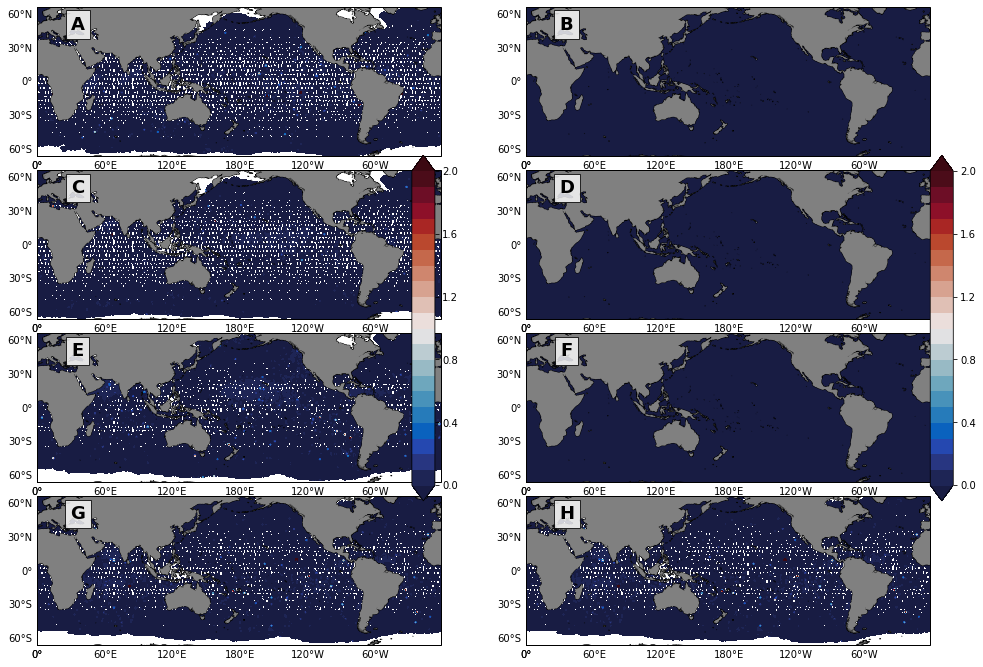

In [14]:
import cartopy.feature as cfeature

projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs1 = ax1.contourf(lon, lat, swh_rchi_sea[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.45, .3, 0.02, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_rchi_sea[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
cax2 = plt.axes([.90, .3, 0.02, 0.4])
cart.set_cbar(cs2, cax2, fig, cbar_label ='', nbins = 6, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs3 = ax3.contourf(lon, lat, swh_rchi_sea[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_rchi_sea[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
cart.set_subplots(ax5, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs5 = ax5.contourf(lon, lat, swh_rchi_sea[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax5 = plt.axes([.47, .17, 0.01, 0.16])
#cart.set_cbar(cs5, cax5, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
cart.set_subplots(ax6, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs6 = ax6.contourf(lon, lat, wsp_rchi_sea[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax6 = plt.axes([.92, .33, 0.01, 0.16])
#cart.set_cbar(cs6, cax6, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

############## Subplot 7  #################
cart.set_subplots(ax7, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs7 = ax7.contourf(lon, lat, swh_rchi_sea[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax7, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax7 = plt.axes([.47, .06, 0.01, 0.16])
#cart.set_cbar(cs7, cax7, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax7, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax7, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'G', fs_shade = 28, fs_main = 18)

############## Subplot 8  #################
cart.set_subplots(ax8, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs8 = ax8.contourf(lon, lat, swh_rchi_sea[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax8, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax8 = plt.axes([.92, .14, 0.01, 0.16])
#cart.set_cbar(cs8, cax8, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax8, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
#ax8.text(0.5, -0.21, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax8.transAxes, fontsize=15)
cart.subplot_label(ax8, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'H', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/ccmp2_ifremer_gof_rchi', bbox_inches = 'tight', dpi=300)




###### Coefficient of Determination

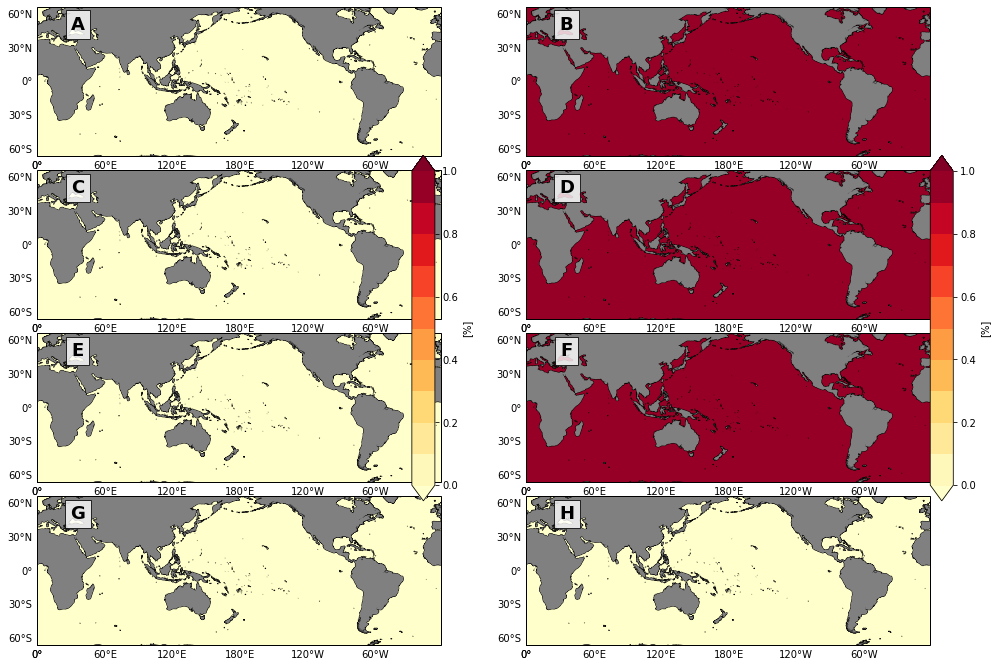

In [15]:
import cartopy.feature as cfeature

projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 1.1, 0.1)
cs1 = ax1.contourf(lon, lat, swh_cod_sea[0,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.45, .3, 0.02, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[%]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_cod_sea[0,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
cax2 = plt.axes([.90, .3, 0.02, 0.4])
cart.set_cbar(cs2, cax2, fig, cbar_label ='[%]', nbins = 6, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs3 = ax3.contourf(lon, lat, swh_cod_sea[1,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_cod_sea[1,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
cart.set_subplots(ax5, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs5 = ax5.contourf(lon, lat, swh_cod_sea[2,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax5 = plt.axes([.47, .17, 0.01, 0.16])
#cart.set_cbar(cs5, cax5, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
cart.set_subplots(ax6, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs6 = ax6.contourf(lon, lat, wsp_cod_sea[2,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax6 = plt.axes([.92, .33, 0.01, 0.16])
#cart.set_cbar(cs6, cax6, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

############## Subplot 7  #################
cart.set_subplots(ax7, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs7 = ax7.contourf(lon, lat, swh_cod_sea[3,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax7, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax7 = plt.axes([.47, .06, 0.01, 0.16])
#cart.set_cbar(cs7, cax7, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax7, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax7, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'G', fs_shade = 28, fs_main = 18)

############## Subplot 8  #################
cart.set_subplots(ax8, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs8 = ax8.contourf(lon, lat, swh_cod_sea[3,:,:], levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax8, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax8 = plt.axes([.92, .14, 0.01, 0.16])
#cart.set_cbar(cs8, cax8, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax8, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
#ax8.text(0.5, -0.21, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax8.transAxes, fontsize=15)
cart.subplot_label(ax8, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'H', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/ccmp2_ifremer_gof_cod', bbox_inches = 'tight', dpi=300)



#### Entire time series 

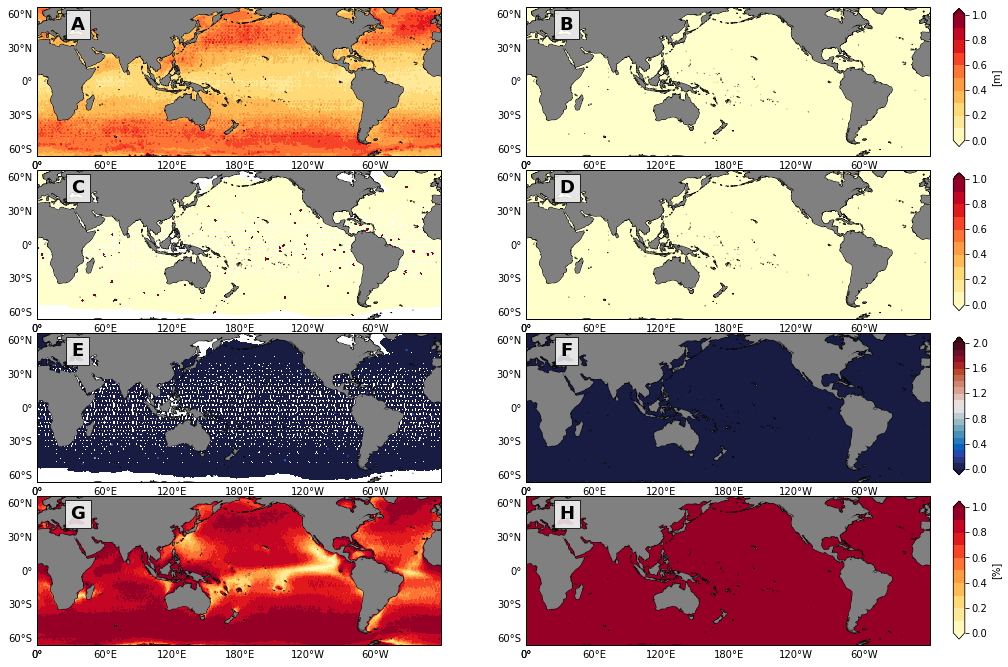

In [20]:
import cartopy.feature as cfeature

projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 1.1, 0.1)
cs1 = ax1.contourf(lon, lat, swh_rms_total, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
#cax1 = plt.axes([.45, .3, 0.02, 0.4])
#cart.set_cbar(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_rms_total, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
cax2 = plt.axes([.92, .71, 0.01, 0.16])
cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 1.1, 0.1)
cs3 = ax3.contourf(lon, lat, swh_chi_total, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 1.1, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_chi_total, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
cax4 = plt.axes([.92, .52, 0.01, 0.16])
cart.set_cbar(cs4, cax4, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
cart.set_subplots(ax5, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 2.1, 0.1)
cs5 = ax5.contourf(lon, lat, swh_rchi_total, levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax5 = plt.axes([.47, .17, 0.01, 0.16])
#cart.set_cbar(cs5, cax5, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
cart.set_subplots(ax6, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 2.1, 0.1)
cs6 = ax6.contourf(lon, lat, wsp_rchi_total, levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
cax6 = plt.axes([.92, .33, 0.01, 0.16])
cart.set_cbar(cs6, cax6, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

############## Subplot 7  #################
cart.set_subplots(ax7, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs7 = ax7.contourf(lon, lat, swh_cod_total, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax7, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax7 = plt.axes([.47, .06, 0.01, 0.16])
#cart.set_cbar(cs7, cax7, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax7, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax7, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'G', fs_shade = 28, fs_main = 18)

############## Subplot 8  #################
cart.set_subplots(ax8, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs8 = ax8.contourf(lon, lat, wsp_cod_total, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax8, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
cax8 = plt.axes([.92, .14, 0.01, 0.16])
cart.set_cbar(cs8, cax8, fig, cbar_label ='[%]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax8, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
#ax8.text(0.5, -0.21, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax8.transAxes, fontsize=15)
cart.subplot_label(ax8, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'H', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/ccmp2_ifremer_gof_tot', bbox_inches = 'tight', dpi=300)


### Developmental code

In [ ]:
start = datetime.datetime(1993, 1, 1)
dt_array = np.array([start + datetime.timedelta(days=i) for i in range(8400)])

In [ ]:
years = np.array([y.year for y in dt_array])
months = np.array([m.month for m in dt_array])
days = np.array([d.day for d in dt_array])
ind_year = years == 1993
ind_mon = months == 1
ind = ind_mon*ind_year

In [ ]:
print(years)

print(months[ind])

In [ ]:
ind_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]*23
ind = np.array(ind_n)
print(ind.shape)

In [ ]:
print(swh_mean_m.shape[0])
print(len(swh_mean_m))

In [ ]:
np.max(swh_mean_m)

In [ ]:
np.max(swh__m)